# Block-encoding Tridiagonal Matrices
======================================

## Setup

In [25]:
#Built-in modules
import numpy as np

#imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator, UnitarySimulator
import qiskit.circuit.library as qulib
from qiskit.quantum_info import Operator
from qiskit import transpile

#Imports from Qiskit Primitives
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService

In [26]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
backend = AerSimulator()  # Use AerSimulator for local simulation

# To run on IBM Quantum hardware, uncomment the following lines
# service = QiskitRuntimeService(channel="ibm_cloud")
# backend = service.least_busy(operational=True, simulator=False)
# backend.name

## Step 1: Map classical inputs to a quantum problem

In [4]:
def TridiagonalBlockEncoding(m, arr):
    """
    Inputs:
    m: number of qubits of operator
    arr: array of size 3 with the values of the diagonal and sub-diagonal elements
    arr[0]: super-diagonal element (gamma)
    arr[1]: diagonal element (alpha)
    arr[2]: sub-diagonal element (beta)

    Outputs:
    Tridiagblckencd: QuantumCircuit object representing the block encoding of the tridiagonal matrix
    """

    # Sparse Block encoding according to paper van Daan Camps 2023 Explicit block encoding of sparse matrices
    n = 2 # Number of Ancilla Qubits

    Tridiagblckencd = QuantumCircuit(n+m+1,name="Tridiagblckencd")

    # Diffusion Operator
    Diffusion = QuantumCircuit(n,name="Diffusion")
    Diffusion.h(range(n))
    Tridiagblckencd.append(Diffusion, list(range(1,n+1)))

    #OA circuit
    OA = QuantumCircuit(n+m+1,name="OA")
    theta0=2*np.arccos(arr[1]-1)
    theta1=2*np.arccos(arr[2])
    theta2=2*np.arccos(arr[0])
    
    
    OA.append(qulib.RYGate(theta0).control(2,ctrl_state="00"),[2,1,0])
    OA.append(qulib.RYGate(theta1).control(2,ctrl_state="01"),[2,1,0])
    OA.append(qulib.RYGate(theta2).control(2,ctrl_state="10"),[2,1,0])
    str="01"+"1"*m
    OA.append(qulib.RYGate(np.pi - theta1).control(n+m,ctrl_state=str),list(range(n+m,-1,-1)))
    str="10"+"0"*m
    OA.append(qulib.RYGate(np.pi - theta2).control(n+m,ctrl_state=str),list(range(n+m,-1,-1)))

    Tridiagblckencd.append(OA, list(range(0,n+m+1)))
    
    #Oc Circuit
    Oc = QuantumCircuit(n+m, name="Oc")
    #Lshift Operator
    Lshift = QuantumCircuit(m, name="Lshift")
    for i in range(m-1):
        Lshift.append(qulib.XGate().control(m-i-1),list(range(m-1,i-1,-1)))
    Lshift.x(m-1)
    Oc.append(qulib.UnitaryGate(Operator(Lshift),label="Lshift").control(1),[1]+list(range(n,n+m)))
    
    #RShift Operator
    Rshift = QuantumCircuit(m,name="Rshift")
    for i in range(m-1):
        str='0'*(m-i-1)
        Rshift.append(qulib.XGate().control(m-i-1,ctrl_state=str),list(range(m-1,i-1,-1)))
    Rshift.x(m-1)
    Oc.append(qulib.UnitaryGate(Operator(Rshift),label="Rshift").control(1),[0]+list(range(n,n+m)))
   
    Tridiagblckencd.append(Oc, list(range(1,n+m+1)))

    # Diffusion Operator
    Tridiagblckencd.append(Diffusion, list(range(1,n+1)))
    
    return Tridiagblckencd
    

## Parameters

In [5]:
# Required conditions
m = 2 # n = 5 number of qubits chosen to implement the matrix, M = 2**m
normalizing_factor = 1.6 # divide by this parameter to make the matrix spectral norm less than 1
M = 2**m # Dimension of the matrix
s = 3 # Sparsity
r = int(np.ceil(np.log2(s)))

# Matrix Parameters
Vx = -0.5 # Vx chosen
alpha = 1 + Vx # Diagonal entry
beta = -0.5 # sub-diagonal entry
gamma= -0.5 # Super-diagonal entry

print("Dimension of Matrix: ",M)
print("Sparsity: ",s)
print("Number of Ancilla qubits: ", r+1)
print("Total Number of Qubits: ", m+r+1)

Dimension of Matrix:  4
Sparsity:  3
Number of Ancilla qubits:  3
Total Number of Qubits:  5


Note that both the constraints for block encoding of general s-sparse matrix which are $\|A\|_{max} = \max_{ij} |A_{ij}| \leq 1$ and $\|A\|_2 \leq 1$ are followed. 

In [6]:
super_diag = np.ones(M-1) * gamma
main_diag = np.ones(M) * alpha
sub_diag = np.ones(M-1) * beta

tridiag_A = np.diag(main_diag) + np.diag(sub_diag, k=-1) + np.diag(super_diag, k=1)
tridiag_A = tridiag_A/normalizing_factor
print("The Matrix is:\n", tridiag_A)
print("The matrix that would be encoded is:\n", tridiag_A/2**r)
print("The matrix spectral Norm is: ",np.linalg.norm(tridiag_A,ord=2))
print(" The maximum value in the matrix is: ", np.max(tridiag_A))
print("The minimum value in the matrix is: ", np.min(tridiag_A))

The Matrix is:
 [[ 0.3125 -0.3125  0.      0.    ]
 [-0.3125  0.3125 -0.3125  0.    ]
 [ 0.     -0.3125  0.3125 -0.3125]
 [ 0.      0.     -0.3125  0.3125]]
The matrix that would be encoded is:
 [[ 0.078125 -0.078125  0.        0.      ]
 [-0.078125  0.078125 -0.078125  0.      ]
 [ 0.       -0.078125  0.078125 -0.078125]
 [ 0.        0.       -0.078125  0.078125]]
The matrix spectral Norm is:  0.8181356214843422
 The maximum value in the matrix is:  0.3125
The minimum value in the matrix is:  -0.3125


#### Solving Eigenvalue problem classically, 
we have to diagonalize the matrix of size $2^m \times 2^m$ where $m$ is the number of qubits. This is computationally expensive and not feasible for large $m$.

In [7]:
#Eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(tridiag_A/2**r)
print("Eigenvalues of A:")
print(eigenvalues)
print("Eigenvectors of A:")
print(eigenvectors)

Eigenvalues of A:
[-0.04828391  0.02984109  0.12640891  0.20453391]
Eigenvectors of A:
[[-0.37174803 -0.60150096 -0.60150096 -0.37174803]
 [-0.60150096 -0.37174803  0.37174803  0.60150096]
 [-0.60150096  0.37174803  0.37174803 -0.60150096]
 [-0.37174803  0.60150096 -0.60150096  0.37174803]]


In [8]:
# Singular Value Decomposition
U, sigma, V = np.linalg.svd(tridiag_A)
print("U = \n",U)
print("V = \n",V)
print("Sigma = \n",sigma)

U = 
 [[-0.37174803 -0.60150096 -0.37174803 -0.60150096]
 [ 0.60150096  0.37174803 -0.60150096 -0.37174803]
 [-0.60150096  0.37174803 -0.60150096  0.37174803]
 [ 0.37174803 -0.60150096 -0.37174803  0.60150096]]
V = 
 [[-0.37174803  0.60150096 -0.60150096  0.37174803]
 [-0.60150096  0.37174803  0.37174803 -0.60150096]
 [ 0.37174803  0.60150096  0.60150096  0.37174803]
 [-0.60150096 -0.37174803  0.37174803  0.60150096]]
Sigma = 
 [0.81813562 0.50563562 0.19313562 0.11936438]


# Simulator

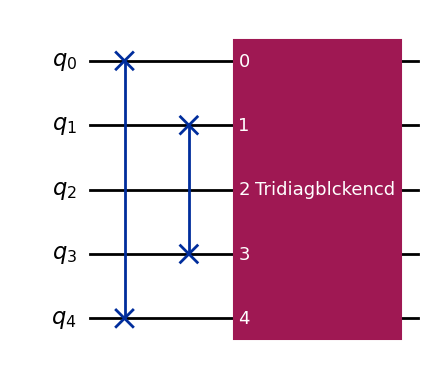

In [ ]:
qc = QuantumCircuit(m+r+1,name="tridiagBE")
# print(m+r+1)

# Add swap gates to reverse the order of qubits
for i in range((m+r+1)//2):
    qc.swap(i, m+r-i)

circuit = TridiagonalBlockEncoding(m,[tridiag_A[0,1],tridiag_A[0,0],tridiag_A[1,0]])
qc.append(circuit,list(range(0,m+r+1)))
qc.draw('mpl')

In [27]:
simulator = UnitarySimulator()
np.set_printoptions(
    threshold=np.inf,    # don't truncate
    linewidth=200,       # prevent line-wrapping
    precision=6,         # number of decimal places
    suppress=True        # avoid scientific notation
)

transpiled_qc = transpile(qc, simulator, optimization_level=3)
result = simulator.run(transpiled_qc).result()
unitary = result.get_unitary(transpiled_qc)
unitary_matrix = unitary[:2**m, :2**m]
print("Extracted unitary matrix:")
print(unitary_matrix.real.round(6))

Extracted unitary matrix:
[[ 0.078125 -0.078125  0.        0.      ]
 [-0.078125  0.078125 -0.078125 -0.      ]
 [ 0.       -0.078125  0.078125 -0.078125]
 [ 0.        0.       -0.078125  0.078125]]


C:\Users\nihar\AppData\Local\Temp\ipykernel_50424\281905596.py:12: DeprecationWarning: The return type of saved unitaries has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Operator` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  unitary_matrix = unitary[:2**m, :2**m]
